In [1]:
import os
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better

from IPython.display import Image, display, SVG, clear_output, HTML

import skimage.io
import skimage.color
import torch_geometric.data
import torch_geometric.utils 

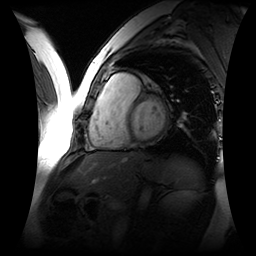

In [2]:
image_file = "data/train/images/0001.png"
image = skimage.io.imread(image_file)
display(Image(image_file))

In [3]:
class ImageGrid(object):
    def __init__(self, array=None, diff_edge=False):
        """[summary]

        Args:
            array ([numpy array], optional): [H W C=1,3 tensor]. Defaults to None.
            diff_edge (bool, optional): [description]. Defaults to False.
        """
        self.reset()
        # self.set_array(array, diff_edge=diff_edge)
        self.array = array.astype(np.float32) if array.ndim == 3 else np.expand_dims(array, axis=2)
        self.height, self.width = array.shape[:2]
    
        # Create the graph
        self.graph = nx.grid_2d_graph(self.height, self.width)
        
        self.set_nodes(weight=None)
        self.set_edges(weight=None, diff_edge=diff_edge)
        # for n, node in enumerate(self.graph.nodes):
        #     print(self.graph.nodes[node])
        self.number_of_nodes = self.graph.number_of_nodes()
        self.number_of_edges = self.graph.number_of_edges()

    def reset(self):
        self.height = 0
        self.width = 0
        self.array = None
        self.graph = None

    def set_edges(self, weight=None, diff_edge=True, cc=4):
        for e, edge in enumerate(self.graph.edges):
            self.graph.edges[edge]['weight'] = 0.5

        if cc==8:
            self.graph.add_edges_from([
                ((x, y), (x+1, y+1))
                for x in range(self.width-1)
                for y in range(self.height-1)
            ] + [
                ((x+1, y), (x, y+1))
                for x in range(self.width-1)
                for y in range(self.height-1)
            ], weight=0.5)
        elif cc==4: 
            # connected component is equal to 4 already in the grid
            pass

        # Add edge to master node 
        for p in [(-1, -1), (-2, -2)]:
            self.graph.add_edges_from([
                ((x, y), p)
                for x in range(self.width)
                for y in range(self.height)
            ], weight=0.5)

        if diff_edge=="mean":
            for e, edge in enumerate(self.graph.edges):
                # Compute the mean of the affinity
                self.graph.edges[edge]['weight'] = (self.array[edge[0]] - self.array[edge[1]]) * 0.5
        elif diff_edge=="diff":
            for e, edge in enumerate(self.graph.edges):
                # Compute the affinity, 1 - difference
                self.graph.edges[edge]['weight'] = ( 1 - np.abs(self.array[edge[0]] - self.array[edge[1]]) )

    def set_nodes(self, weight=None):
        for n, node in enumerate(self.graph.nodes):
            y = n // self.width
            x = n % self.width
            self.graph.nodes[node]['weight'] = self.array[y,x,:] \
                if weight is None else np.array([weight], dtype=np.float32)
        # Set master node 
        self.graph.add_node((-1, -1), weight=np.array([0.0], dtype=np.float32) if weight is None else np.array([weight], dtype=np.float32)) 
        self.graph.add_node((-2, -2), weight=np.array([1.0], dtype=np.float32) if weight is None else np.array([weight], dtype=np.float32)) 
        # for p in [(-1, -1), (-2, -2)]:
        #     self.graph.add_node(p, weight=np.array([0.0], dtype=np.float32) \
        #         if weight is None else np.array([weight], dtype=np.float32)) 
        # for p in [(-3, -3), (-4, -4)]:
        #     self.graph.add_node(p, weight=np.array([1.0], dtype=np.float32) \
        #         if weight is None else np.array([weight], dtype=np.float32)) 
        # self.graph.nodes[(-1, -1)]['weight'] = 0.5 if weight is None else weight

# image_grid = ImageGrid(array=image[:28, :28].copy())
for s in list([2, 3, 4, 28, 256]):
    print("="*20)
    image_grid = ImageGrid(array=(image.copy()[:s,:s]) / 255, diff_edge="diff")
    print(len(image_grid.graph.nodes))
    print(len(image_grid.graph.edges))

    G = image_grid.graph
    data = torch_geometric.utils.from_networkx(G, 
        group_node_attrs=['weight'],
        group_edge_attrs=['weight'])
    print(data)

6
12
Data(edge_index=[2, 24], x=[6, 1], edge_attr=[24, 1])
11
30
Data(edge_index=[2, 60], x=[11, 1], edge_attr=[60, 1])
18
56
Data(edge_index=[2, 112], x=[18, 1], edge_attr=[112, 1])
786
3080
Data(edge_index=[2, 6160], x=[786, 1], edge_attr=[6160, 1])
65538
261632
Data(edge_index=[2, 523264], x=[65538, 1], edge_attr=[523264, 1])


In [4]:
# # 
# def draw_grid(G, arr=None, ax=None):
#     """[summary]

#     Args:
#         G ([type]): [description]
#         arr ([type], optional): [channel last tensor]. Defaults to None.
#         ax ([type], optional): [description]. Defaults to None.
#     """
#     # assert len(G) == len(arr.mean(axis=-1).flatten())
#     pos = dict(zip(G,G))
#     width, height = arr.shape[:2]
#     if ax is None:
#         fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#     else:
#         fig = None
    
#     node_color = []
#     node_label = {}
#     for n, node in enumerate(G):
#         #node_color.append(G.nodes[k].get('color', 'green'))
#         y = n // width
#         x = n % width
#         if n < width * height:
#             node_color.append(arr[y,x,:]) if arr is not None else 1
#             node_label[node] = G.nodes[node].get('label', n)

#     edge_color = []
#     edge_width = []
#     for edge in G.edges():
#         edge_color.append(G.edges[edge].get('color', 'blue'))
#         edge_width.append(G.edges[edge].get('width', 1))

#     # nx.draw_networkx_edges(G, pos=pos, edge_color=edge_color, alpha=0.50, ax=ax, width=edge_width)
#     nx.draw_networkx_nodes(G, pos=pos, node_color=node_color, alpha=0.75, ax=ax, node_shape='s', node_size=100)
#     fig.tight_layout()
#     ax.margins(0.0)
#     ax.axis('off')
#     ax.autoscale()

# draw_grid(image_grid.graph, arr=np.rot90(image_grid.array, -1), ax=None)

In [5]:
display(len(image_grid.graph))
display(len(image_grid.array.flatten()))

65538

65536

In [6]:
# vars(image_grid.edge_attr)

In [7]:
import torch
import torch_geometric.utils as geom_utils

def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return geom_utils.normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

def attributed_cut_2d(edge_index, edge_attr, num_nodes):
    return geom_utils.normalized_cut(edge_index, edge_attr, num_nodes)

pG = geom_utils.from_networkx(image_grid.graph)
print(pG.keys)
for key in pG.keys:
    print(key, pG[key])
# pC = normalized_cut_2d(pG.edge_index, pG.pos)
# pC = attributed_cut_2d(pG.edge_index, pG.weight, pG.num_nodes)
pC = geom_utils.normalized_cut(pG.edge_index, pG.weight, pG.num_nodes)
print(pC.shape)



['weight', 'edge_index', 'edge_weight', 'num_nodes']
weight tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]], dtype=torch.float64)
edge_index tensor([[    0,     0,     0,  ..., 65537, 65537, 65537],
        [  256,     1, 65536,  ..., 65533, 65534, 65535]])
edge_weight tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], dtype=torch.float64)
num_nodes 65538


RuntimeError: [enforce fail at CPUAllocator.cpp:71] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 274349408256 bytes. Error code 12 (Cannot allocate memory)